In [1]:
from SimPEG import Mesh, Utils, EM
from pymatsolver import Pardiso
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
from TDEM import ProblemSkyTEM
%matplotlib inline

In [2]:
sigma_background = 1./100.
sigma_target = 1./100.
resistivity_background = 1./sigma_background
resistivity_target = 1./sigma_target
resistivity = np.array([resistivity_background, resistivity_target, resistivity_background], dtype=float)
thickness = np.array([50, 40], dtype=float)
source_area = 536.36
data_dir = "/Users/sgkang/Dropbox/Stanford/Resolution/aarhusinv/em1dinv_examples/notebooks/"
waveform_hm = np.loadtxt(data_dir+"HM_butte_304.txt")
time_gates_hm = np.loadtxt(data_dir+"HM_butte_304_gates")[7:,:] * 1e-6
waveform_lm = np.loadtxt(data_dir+"LM_butte_304.txt")
time_gates_lm = np.loadtxt(data_dir+"LM_butte_304_gates")[8:,:] * 1e-6

time_input_currents_HM = waveform_hm[:,0]
input_currents_HM = waveform_hm[:,1]
time_input_currents_LM = waveform_lm[:,0]
input_currents_LM = waveform_lm[:,1]
    
time_LM = time_gates_lm[:,3] - waveform_lm[:,0].max()
time_HM = time_gates_hm[:,3] - waveform_hm[:,0].max()
source_area = 536.36

In [3]:
from simpegEM1D import diffusion_distance

In [4]:
diffusion_distance(1e-2, 1./50.) * 2

1784.1241161527712

In [5]:
from discretize import utils
rxloc = np.array([13.25, 0., 30.+2.])
srcloc = np.array([0., 0., 30.])
xyz = np.vstack((rxloc, srcloc))
x = np.linspace(-100., 100.)
y = np.linspace(-20., 20.)
dem = Utils.ndgrid(x,y,np.r_[0.])
h = [10., 10., 5]
mesh = utils.mesh_builder_xyz(
    dem,
    h,
    padding_distance=[[2000., 2000.], [2000., 2000.], [2000., 2000.]],
    base_mesh=None,
    depth_core=None,
    expansion_factor=1.3,
    mesh_type='tree'
)

mesh = utils.refine_tree_xyz(
    mesh,
    dem,
    method='surface',
    octree_levels=[1, 0, 5],
    octree_levels_padding=None,
    finalize=False,
    min_level=0,
    max_distance=np.inf,    
)

# x = np.linspace(-300., 300.)
# y = np.linspace(-300., 300.)
# dem = Utils.ndgrid(x,y,np.r_[0.])

# mesh = utils.refine_tree_xyz(
#     mesh,
#     dem,
#     method='surface',
#     octree_levels=[0, 0, 1],
#     octree_levels_padding=None,
#     finalize=False,
#     min_level=0,
#     max_distance=np.inf,    
# )

mesh = utils.refine_tree_xyz(
    mesh,
    xyz,
    method='radial',
    octree_levels=[2, 0, 0],
    octree_levels_padding=None,
    finalize=True,
    min_level=0,
    max_distance=np.inf,    
)

In [6]:
mesh.nC

1731

In [7]:
sigma = np.ones(mesh.nC) * 1e-8
sigma[mesh.gridCC[:,2]<0.] = sigma_background
inds = np.logical_and(mesh.gridCC[:,2]<-50, mesh.gridCC[:,2]>-100)
sigma[inds] = sigma_target

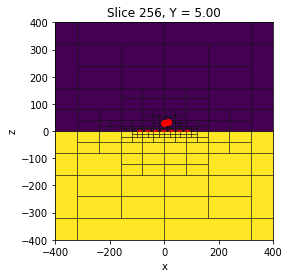

In [8]:
mesh.plotSlice(sigma, grid=True, normal='Y')
plt.plot(xyz[:,0], xyz[:,2], 'ro')
plt.plot([-100, 100], [0, 0], 'r--')
plt.xlim(-400, 400)
plt.ylim(-400, 400)
plt.gca().set_aspect(1)

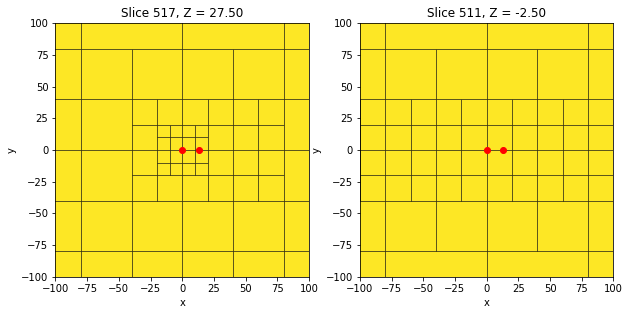

In [9]:
fig, axs = plt.subplots(1,2, figsize = (10, 5))
zc = 30.
indz = int(np.argmin(abs(mesh.vectorCCz-zc)))
mesh.plotSlice(np.ones(mesh.nC), grid=True, normal='Z', clim=(0, 1), ind=indz, ax=axs[0])
zc = 0.
indz = int(np.argmin(abs(mesh.vectorCCz-zc)))
mesh.plotSlice(np.ones(mesh.nC), grid=True, normal='Z', clim=(0, 1), ind=indz, ax=axs[1])
for ax in axs:
    ax.plot(xyz[:,0], xyz[:,1], 'ro')
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    ax.set_aspect(1)


In [10]:
z_src = 30
x_rx = 13.25
z_offset = 2.
rxloc = np.array([x_rx, 0., z_src+z_offset])
srcloc = np.array([0., 0., z_src])
rx = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-6), np.log10(1e-2), 31), 'z')
# src = EM.TDEM.Src.CircularLoop([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius=13.)
src = EM.TDEM.Src.MagDipole([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc)
survey = EM.TDEM.Survey([src])
prb = ProblemSkyTEM(mesh, sigma=sigma, verbose=False)
dts = np.diff(np.logspace(-6, -1, 50))
# timeSteps = []
# for dt in dts:
#     timeSteps.append((dt, 1))
# prb.timeSteps = timeSteps
prb.timeSteps = [(3e-7, 6),(1e-6, 5),(2e-6, 5),(5e-6, 5),(1e-5, 5),(2e-5, 5),(5e-5, 5),(1e-4, 5),(2e-4, 5),(5e-4, 5),(1e-3, 15)]
prb.Solver = Pardiso
prb.pair(survey)

In [11]:
# %%time
data_hm, data_lm = prb.simulate(
    [],
    time_HM,
    time_LM,
    time_input_currents_HM, 
    input_currents_HM,
    time_input_currents_LM, 
    input_currents_LM,    
)

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:400: UserWarning: Cannot add model as there are no active mappings, choose from: ['rhoMap', 'sigmaMap']
  "', '".join(self._all_map_names)


In [12]:
from simpegEM1D import EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, set_mesh_1d, piecewise_pulse
from SimPEG import Maps
def simulation(src_type, n_pulse=1, use_lowpass_filter=True):
    hz = np.r_[thickness.copy(), 1e3]
    mesh1D = set_mesh_1d(hz)
    depth = -mesh1D.gridN[:-1]

    if src_type == "CircularLoop":
        # Effective radius
        radius = np.sqrt(source_area/np.pi)        
        TDsurvey = EM1DSurveyTD(
            rx_location = np.array([0., 0., 100.+30.]),
            src_location = np.array([0., 0., 100.+30.]),
            topo = np.r_[0., 0., 100.],
            depth = depth,
            rx_type = 'dBzdt',
            wave_type = 'general',
            src_type = 'CircularLoop',    
            I = 1,    
            a = radius,
            time = time_HM,
            time_input_currents=time_input_currents_HM,
            input_currents=input_currents_HM,
            n_pulse = n_pulse,
            base_frequency = 30.,
            use_lowpass_filter=use_lowpass_filter,
            high_cut_frequency=210*1e3,
            moment_type='dual',
            time_dual_moment = time_LM,    
            time_input_currents_dual_moment=time_input_currents_LM,
            input_currents_dual_moment=input_currents_LM,
            base_frequency_dual_moment=210,    
        )
    elif src_type == "VMD":
        TDsurvey = EM1DSurveyTD(
            rx_location = np.array([0., 0., 100.+30.+2.]),
            src_location = np.array([0., 0., 100.+30.]),
            topo = np.r_[0., 0., 100.],
            depth = depth,
            rx_type = 'dBzdt',
            wave_type = 'general',
            src_type = 'VMD',    
            offset=np.array([13.25]),
            I = 1.,
            time = time_HM,
            time_input_currents=time_input_currents_HM,
            input_currents=input_currents_HM,
            n_pulse = n_pulse,
            base_frequency = 30.,
            use_lowpass_filter=use_lowpass_filter,
            high_cut_frequency=210*1e3,
            moment_type='dual',
            time_dual_moment = time_LM,    
            time_input_currents_dual_moment=time_input_currents_LM,
            input_currents_dual_moment=input_currents_LM,
            base_frequency_dual_moment=210,    
        )
    chi_half = 0.
    expmap = Maps.ExpMap(mesh1D)
    print (resistivity)
    prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
    m_true = np.log(1./resistivity)
    if prob.ispaired:
        prob.unpair()
    if TDsurvey.ispaired:
        TDsurvey.unpair()
    prob.pair(TDsurvey)
    prob.chi = np.zeros(TDsurvey.n_layer)
    d_true = -TDsurvey.dpred(m_true)
    return d_true

[100. 100. 100.]


Text(0, 0.5, 'Voltage (V/A)')

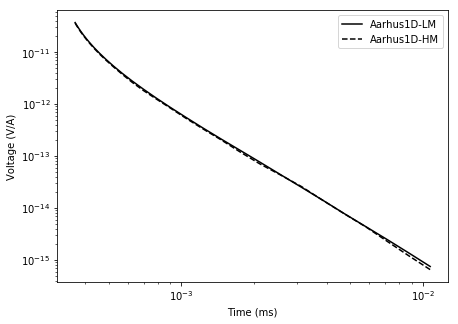

In [13]:
d_true = simulation('VMD', use_lowpass_filter=False, n_pulse=1)
n_time = time_HM.size
fig, axes = plt.subplots(1,1, figsize = (7,5))
axes.plot(time_gates_hm[:,3], d_true[:n_time], 'k-')
axes.plot(time_gates_hm[:,3], -data_hm.flatten(), 'k--')
axes.set_xscale('log');
axes.set_yscale('log');
plt.legend(("Aarhus1D-LM", "Aarhus1D-HM", "simpeg-LM", "simpeg-HM"))
axes.set_xlabel("Time (ms)")
axes.set_ylabel("Voltage (V/A)")

Text(0, 0.5, 'Voltage (V/A)')

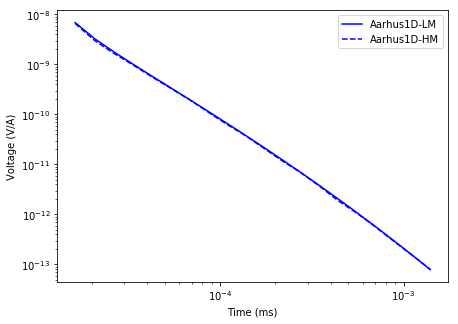

In [14]:
fig, axes = plt.subplots(1,1, figsize = (7,5))
axes.plot(time_gates_lm[:,3], d_true[n_time:], 'b-')
axes.plot(time_gates_lm[:,3], -data_lm.flatten(), 'b--')

axes.set_xscale('log');
axes.set_yscale('log');
plt.legend(("Aarhus1D-LM", "Aarhus1D-HM", "simpeg-LM", "simpeg-HM"))
axes.set_xlabel("Time (ms)")
axes.set_ylabel("Voltage (V/A)")